<h1> PyTorch in a nutshell </h1> 

PyTorch is a module built for working with tensors and particularly adapt for building deep learning models in image recognition and language processing. As a python module, it aims to be easy to implement and provide code that is generally very readable.
In this notebook we will follow the tutorial presented on the [PyTorch Page](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), which mainly focuses on computer vision applications. 

The required modules can be installed on the conda environment with:

In [1]:
!conda install pytorch torchvision torchaudio -c pytorch

Retrieving notices: ...working... done
Solving environment: done

# All requested packages already installed.



we can then test the modules are correctly installed by importing them

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

<h2> Tensors in PyTorch</h2> 

Tensors are a data structure of PyTorch similar to numpy arrays, which are however optimized to be run on GPU or other hardware accellerators. Tensors are also optimized for automatic differentiation, making them the perfect tools for training a NN.

We can create tensors:

<h4> Directly from data</h4> 

In [3]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

<h4> From numpy array</h4> 

In [4]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

<h4> With random or constant variables </h4> 

In [5]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.7369, 0.1204, 0.6901],
        [0.6880, 0.2676, 0.0372]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


<h4> From other tensors</h4> 

In [6]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8871, 0.4767],
        [0.0807, 0.3207]]) 



<h3> Tensors attributes</h3> 

The main attributes defining a tensor are their shape, data type, and device on which they are stored:

In [7]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


<h3> Operations on Tensors</h3> 

PyTorch generally offers hundreds of operations on tensors, coming from arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing) and sampling. For a full list of the operations allowed check [here](https://pytorch.org/docs/stable/torch.html)!

In the following we will describe some of the most common operations on tensors.

<h4> Move from CPU to GPU</h4> 

In [8]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

<h4>Standard numpy-like indexing and slicing</h4> 

In [9]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


<h4> Joining tensors  </h4> 

In [10]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


<h4> Arithmetic operations </h4> 

In [11]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

<h4> Tensors to scalar conversion</h4> 

In [12]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


<h4> In-place operations </h4> 

Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: $x.copy\_(y)$, $x.t\_()$, will change x.

This operations are discouraged when computing derivatives as they break the derivative cycle!!!

In [13]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


<h3> Bridge with numpy </h3> 

In general, there is a strong link between tensors and numpy objects!

we can easily convert a tensor to a numpy array with:

In [14]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


a change in the tensor will also affect the numpy array:

In [15]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


We can also do the vice-versa as follows:

In [16]:
n = np.ones(5)
t = torch.from_numpy(n)

and have the same linking:

In [17]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


<h2> Data loading on PyTorch </h2> 

PyTorch provides two data primitives: $torch.utils.data.DataLoader$ and $torch.utils.data.Dataset$ that allow you to use pre-loaded datasets as well as your own data. 

$Dataset$ stores the samples and their corresponding labels, and $DataLoader$ wraps an iterable around the Dataset to enable easy access to the samples.

<h3> Downloading a pytorch standard dataset</h3> 

The $torchvision.dataset$ module include several training and test sets that can be downloaded, following the PyTorch tutorial we are going to download the _FashionMNIST_ dataset.

In [18]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

we then need to prepare the data for the dataloader and understand what is the size of the input data:

In [19]:
batch_size = 64 # Each iterable element will return to the dataloader batch_size features and labels before updating the weights

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for x, y in test_dataloader:
    print(f"Shape of x [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


<h3> Iterating and visualizing the dataset </h3> 

In order to understand the type of data we are working with, it's usefull to show their elements and the associated labels.

We can do that by first creating a map, and then running the following:

In [20]:
# Labels are stored as numbers for ease of the classification algorithm, we can convert them into proper label with the following map 

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

we can then simply plot the elements of the dataset with their associated label with $matplotlib$

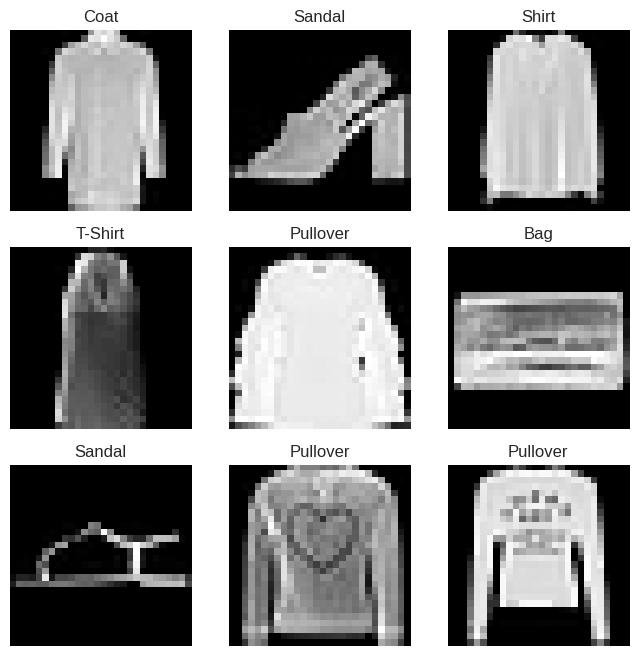

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

<h2> Creating a custom dataset</h2> 

When creating a custom Dataset class, we need to implement the three functions: $\_\_init\_\_$, $\_\_len\_\_$, and $\_\_getitem\_\_$. 
We generally save all the images in the $img\_dir$, while their labels are generally stored separately in a CSV file $annotations\_file$.

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

<h2> Iterating on the Dataloader</h2> 

We can now use the iterator to show some image with their label, as the shuffle was set to true it is supposed to change on each run

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


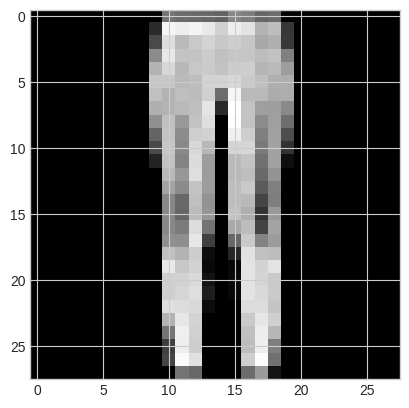

Label: 1


In [23]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

<h2> Transformations on the dataset </h2> 

When working with proper datasets, data rarely come ready to be handled in a training algorithm.
Fortunately, PyTorch allows to perform some data manipulation to make it more suitable for training.

All TorchVision datasets have two parameters $-transform$ to modify the features and $target\_transform$ to modify the labels.
Several type of transformations are already available in the $torchvision.transforms$ module, which are described in detail [here](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html).

The previously loaded _FashionMNIST_ features are in PIL Image format, and the labels are integers. 
For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use $ToTensor$ and $Lambda$.

In [24]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # Transforms the images to tensors, also normalize them into the [0,1] range
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) # Transforms the target classes to numerical scalars
)

<h2> Defining the neural network</h2> 

We can now define the neural network model, to begin, let's check if cuda is available as the NN will perform much better when run on GPU.
If not we will run on cpu

In [25]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available() # GPU optimization
    else "mps"
    if torch.backends.mps.is_available() # Optimization for mac
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


we can then define the NN class that will be trained from the data, following the tutorial we will define it as follows:

In [26]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # Inherit methods from the nn.module
        self.flatten = nn.Flatten() # Reduce the dimensions of the feature input map to make it understandable from next layer (from 28*28 to 784)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # Linear layer on the input, first value is the size of the image, second the choosen number of nodes
            nn.ReLU(), # Nonlinear activations used to introduce non linearities after the linear transformation
            nn.Linear(512, 512), # Hidden layer, generally nodes * nodes
            nn.ReLU(), # Nonlinear activations used to introduce non linearities after the linear transformation
            nn.Linear(512, 10) # Output layer, given by nodes*number of output classess
        )

    def forward(self, x): # forward step to train the model from data
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


the model parameters can be printed with:

In [27]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0186, -0.0349, -0.0293,  ...,  0.0297,  0.0082, -0.0065],
        [ 0.0064,  0.0168, -0.0291,  ...,  0.0084,  0.0344,  0.0229]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0006,  0.0289], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0392,  0.0233, -0.0147,  ...,  0.0050,  0.0026,  0.0438],
        [-0.0020,  0.0287,  0.0389,  ...,  0.0308, -0.0233,  0.0341]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

we can estimate the output given a image by applying the model and calling a softmax function:

In [28]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits) # predicted probability of the classes, we normalize the sum to 1 after the last linear layer to obtain them
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0])


<h2> Training the neural network given the input data</h2> 

In order to train the neural network, we first have to define a _Loss function_ and an optimizer. 
These are already available in the torch environment, and following the tutorial we will use:

In [29]:
#Parameters of the training

learning_rate = 1e-3 # how much we update the models after each iteration, higher value can cause unpredictable behavior and stop convergency
epochs = 5 # number of times we iterate the learning procedure over the dataset, each epoch first update by running on the train data and then validate by running on the test one

loss_fn = nn.CrossEntropyLoss() # Function to minimize during training, Cross entropy basically represent the difference between the estimated probability of the distributions of values and the original
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # The optimizer will use stochastic gradient descent

other optimizers with their description can be found [here](https://pytorch.org/docs/stable/optim.html).

In the training step we will then make a predictions on the training set, and backpropagates the errors to improve the coefficients

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

to avoid overfitting on the training set, we also need to check its performance on the test set 

In [31]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The learning process will be run over several epochs, if the model is converging we should see it's precision getting better after each training epoch:

In [32]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304461  [   64/60000]
loss: 2.297689  [ 6464/60000]
loss: 2.287058  [12864/60000]
loss: 2.267308  [19264/60000]
loss: 2.258850  [25664/60000]
loss: 2.219006  [32064/60000]
loss: 2.220084  [38464/60000]
loss: 2.214756  [44864/60000]
loss: 2.190586  [51264/60000]
loss: 2.176018  [57664/60000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.161779 

Epoch 2
-------------------------------
loss: 2.158788  [   64/60000]
loss: 2.122853  [ 6464/60000]
loss: 2.105380  [12864/60000]
loss: 2.070921  [19264/60000]
loss: 2.077020  [25664/60000]
loss: 2.043927  [32064/60000]
loss: 2.049787  [38464/60000]
loss: 2.018987  [44864/60000]
loss: 1.929705  [51264/60000]
loss: 1.896605  [57664/60000]
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.894676 

Epoch 3
-------------------------------
loss: 1.918278  [   64/60000]
loss: 1.868322  [ 6464/60000]
loss: 1.829418  [12864/60000]
loss: 1.792903  [19264/60000]
loss: 1.756542  [25664/60000]
loss: 1.741294  [32064/600

we can now make predictions with our model:

In [33]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


<h2> Saving and loading pre-trained models </h2> 

Training a model properly generally require long time, once the training process is done we can hence save the trained model so that we can just reload it when we need to use it.

To save the model we proceed as follows:

In [34]:
torch.save(model.state_dict(), "./Output/FashionMNISTModel.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


which can then be loaded as:

In [35]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("./Output/FashionMNISTModel.pth"))

<All keys matched successfully>